In [301]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest

sns.set(style="whitegrid")
pd.set_option('display.max_columns', 100)

# Load data (update path if needed)
df_ap = pd.read_csv("/content/drive/MyDrive/Case Study Data/credit_risk_applicants.csv")
df_pl = pd.read_csv("/content/drive/MyDrive/Case Study Data/credit_risk_previous_loans.csv")

df_ap.head()
df_pl.head()


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [302]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1. Quick Data Overview

Applicants shape: (307511, 122)
Previous loans shape: (1670214, 37)

TARGET distribution (%):
TARGET
0    91.927118
1     8.072882
Name: proportion, dtype: float64
TARGET
0    282686
1     24825
Name: count, dtype: int64


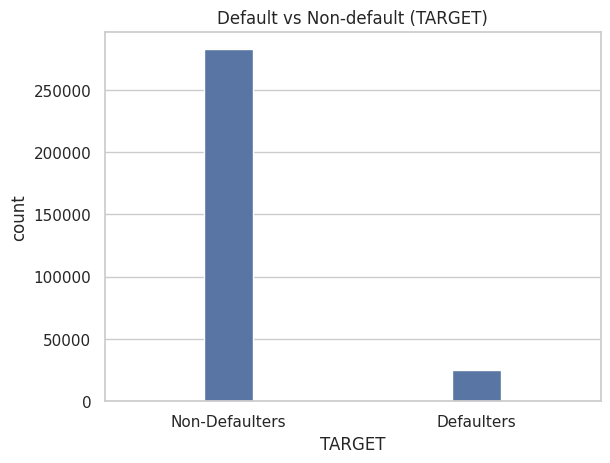

In [303]:
print("Applicants shape:", df_ap.shape) #shape of applicants
print("Previous loans shape:", df_pl.shape) #shape of prev loans

print("\nTARGET distribution (%):")
print(df_ap['TARGET'].value_counts(normalize=True) * 100) #shows the percentage
print(df_ap['TARGET'].value_counts()) #shows the count
sns.countplot(x='TARGET', data=df_ap,width=0.2) #we plot Target on X-axis
plt.xticks(ticks=[0, 1], labels=['Non-Defaulters', 'Defaulters'])
plt.title("Default vs Non-default (TARGET)")
plt.show()


In [304]:
m_per = (df_ap.isnull().sum() / len(df_ap)) * 100
m_per = m_per.sort_values(ascending=False)

missing_df = pd.DataFrame({
    'Column': m_per.index,
    'Missing %': m_per.values.round(2)
})

missing_df.head(20)  # show top 20 columns with highest missing %


,Column,Missing %
0,COMMONAREA_AVG,69.87
1,COMMONAREA_MODE,69.87
2,COMMONAREA_MEDI,69.87
3,NONLIVINGAPARTMENTS_MEDI,69.43
4,NONLIVINGAPARTMENTS_MODE,69.43
5,NONLIVINGAPARTMENTS_AVG,69.43
6,FONDKAPREMONT_MODE,68.39
7,LIVINGAPARTMENTS_AVG,68.35
8,LIVINGAPARTMENTS_MEDI,68.35
9,LIVINGAPARTMENTS_MODE,68.35


In [305]:
m_pl = (df_pl.isnull().sum()/len(df_pl))*100
m_pl = m_pl.sort_values(ascending=False)
pd.DataFrame({'Column': m_pl.index,
              'Missing %': m_pl.values.round(2)})


,Column,Missing %
0,RATE_INTEREST_PRIVILEGED,99.64
1,RATE_INTEREST_PRIMARY,99.64
2,AMT_DOWN_PAYMENT,53.64
3,RATE_DOWN_PAYMENT,53.64
4,NAME_TYPE_SUITE,49.12
5,DAYS_TERMINATION,40.30
6,DAYS_FIRST_DRAWING,40.30
7,DAYS_FIRST_DUE,40.30
8,DAYS_LAST_DUE_1ST_VERSION,40.30
9,DAYS_LAST_DUE,40.30


2. Data Cleaning & Basic Feature Engineering

We fix days fields, handle obvious anomalies, and fill key missing values.

In [306]:
# Age and employment in years
df_ap['AGE_YEARS'] = (-df_ap['DAYS_BIRTH']) / 365
# as days are -ve we add +ve,convert to +ve and convert to years

if 'DAYS_EMPLOYED' in df_ap.columns:
    df_ap['EMP_YEARS'] = (-df_ap['DAYS_EMPLOYED']) / 365

In [307]:
'''
# Common anomaly in DAYS_EMPLOYED (e.g., 365243 days placeholder)
df_ap.loc[df_ap['EMP_YEARS'] > 80, 'EMP_YEARS'] = np.nan

#eg.emp with 365243=1000 years unrealistic data so replace that with 'nan'

df_ap['EMP_YEARS'].fillna(df_ap['EMP_YEARS'].median(), inplace=True)
#filling the null values with median, inplace =true means modify original'''

"\n# Common anomaly in DAYS_EMPLOYED (e.g., 365243 days placeholder)\ndf_ap.loc[df_ap['EMP_YEARS'] > 80, 'EMP_YEARS'] = np.nan\n\n#eg.emp with 365243=1000 years unrealistic data so replace that with 'nan'\n\ndf_ap['EMP_YEARS'].fillna(df_ap['EMP_YEARS'].median(), inplace=True)\n#filling the null values with median, inplace =true means modify original"

In [308]:
df_ap.loc[df_ap['EMP_YEARS'] < 0, 'EMP_YEARS'] = 0
df_ap['EMP_YEARS'] = df_ap['EMP_YEARS'].clip(upper=50)
print(df_ap['EMP_YEARS'].describe())

count    307511.000000
mean          5.355748
std           6.320737
min           0.000000
25%           0.791781
50%           3.323288
75%           7.561644
max          49.073973
Name: EMP_YEARS, dtype: float64


In [309]:
# Fill external score missing values (if present)
#External score= External Credit Bureau / Credit Scoring data, Highly predictive of default risk
for col in ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']:
    if col in df_ap.columns:
        df_ap[col].fillna(df_ap[col].median(), inplace=True)

/tmp/ipython-input-3619120694.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_ap[col].fillna(df_ap[col].median(), inplace=True)


In [310]:
# Simple outlier capping on money columns, to handle outliers, removing outliers
for col in ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']:
    if col in df_ap.columns:
        lower = df_ap[col].quantile(0.01) #lower cutoff
        upper = df_ap[col].quantile(0.99) #upper cutoff
        #this removes the extreme values at both end

        df_ap[col] = df_ap[col].clip(lower, upper)#keep values in realistic limit,prevent bias by extreme numbers


df_ap[['AGE_YEARS', 'EMP_YEARS']].describe()

,AGE_YEARS,EMP_YEARS
count,307511.000000,307511.000000
mean,43.936973,5.355748
std,11.956133,6.320737
min,20.517808,0.000000
25%,34.008219,0.791781
50%,43.150685,3.323288
75%,53.923288,7.561644
max,69.120548,49.073973


3. Previous Loans → Aggregate Features & Merge

We summarize past loans per customer and bring them into df_ap.

In [311]:
# Create aggregated features from previous loans dataset
if 'SK_ID_CURR' in df_ap.columns and 'SK_ID_CURR' in df_pl.columns: #Ensure that both datasets share the same key column

    prev_agg = df_pl.groupby('SK_ID_CURR').agg( #Group previous loans by customer ID
        PREV_LOAN_COUNT=('SK_ID_CURR','size'), #Number of previous loan applications
        PREV_AMT_CREDIT_MEAN=('AMT_CREDIT','mean'), #Average credit amount applied in past loans
        PREV_AMT_APP_MEAN=('AMT_APPLICATION','mean'), #Average requested amount across past applications
        PREV_CNT_PAY_MEAN=('CNT_PAYMENT','mean'), #Average number of installments taken
        PREV_REFUSED_COUNT=('NAME_CONTRACT_STATUS', #Count how many times loan requests were rejected earlier
                            lambda x: (x == 'Refused').sum())
    )

    # Refusal rate = refused / total previous loans
    prev_agg['PREV_REFUSAL_RATE'] = (
        prev_agg['PREV_REFUSED_COUNT'] / prev_agg['PREV_LOAN_COUNT']
    )

    # Merge with applicants dataset
    df_ap = df_ap.merge(prev_agg, on='SK_ID_CURR', how='left') #left==> bring all the rows from left df and only matching rows from right

    # Fill missing with 0 for customers having no previous loans
    df_ap.fillna({
        'PREV_LOAN_COUNT': 0,
        'PREV_AMT_CREDIT_MEAN': 0,
        'PREV_AMT_APP_MEAN': 0,
        'PREV_CNT_PAY_MEAN': 0,
        'PREV_REFUSED_COUNT': 0,
        'PREV_REFUSAL_RATE': 0
    }, inplace=True)

    print("Previous loan features added successfully!")
else:
    print("SK_ID_CURR missing in one of the datasets.")


Previous loan features added successfully!


4.Univariate


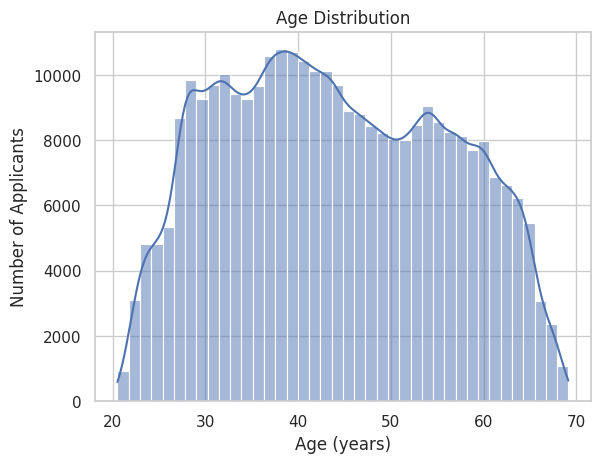

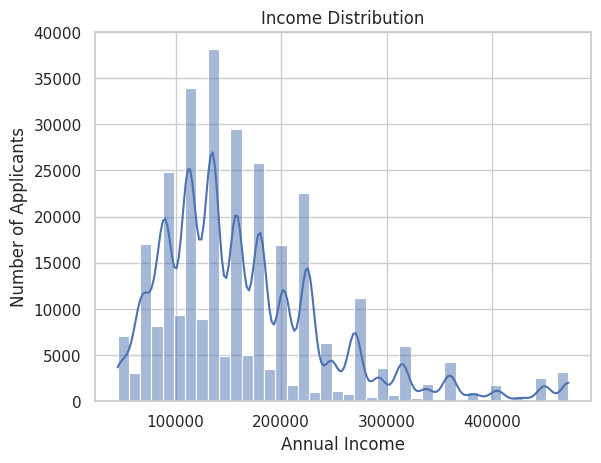

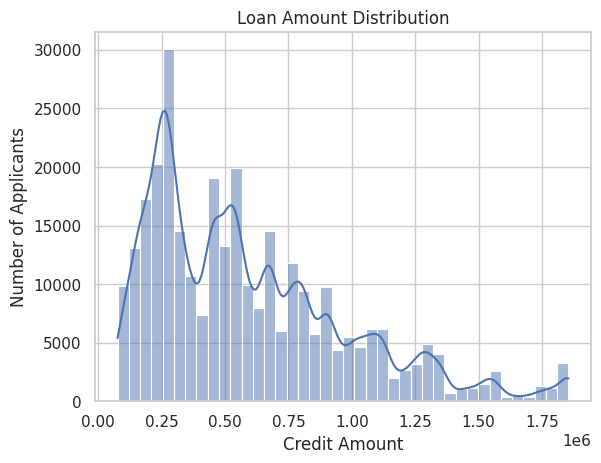

In [312]:
# Age
sns.histplot(df_ap['AGE_YEARS'], bins=40, kde=True)
#bins=splits the data range into 50 small intervals, KDE=adds smooth curve on top of the histogram to show the shape of the distribution
plt.title("Age Distribution")
plt.xlabel("Age (years)")
plt.ylabel("Number of Applicants")
plt.show()

# Income
sns.histplot(df_ap['AMT_INCOME_TOTAL'], bins=40, kde=True)
plt.title("Income Distribution")
plt.xlabel("Annual Income")
plt.ylabel("Number of Applicants")
plt.show()

# Credit amount
sns.histplot(df_ap['AMT_CREDIT'], bins=40, kde=True)
plt.title("Loan Amount Distribution")
plt.xlabel("Credit Amount")
plt.ylabel("Number of Applicants")
plt.show()


4.2 Basic Categorical Distributions

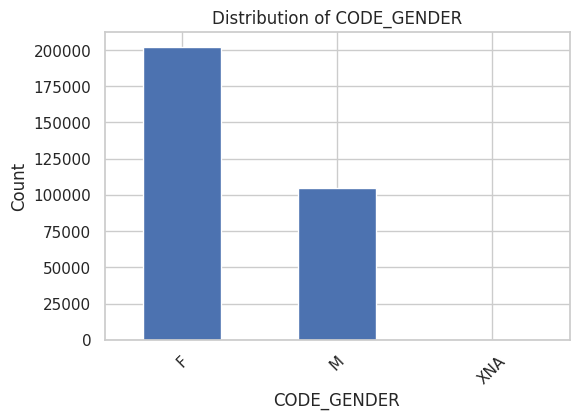

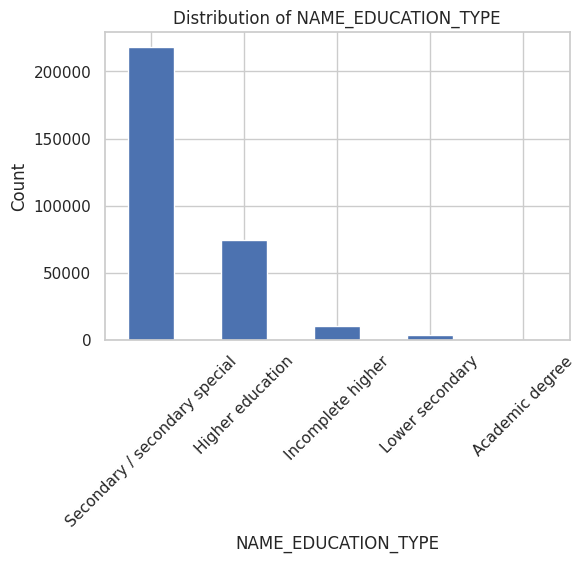

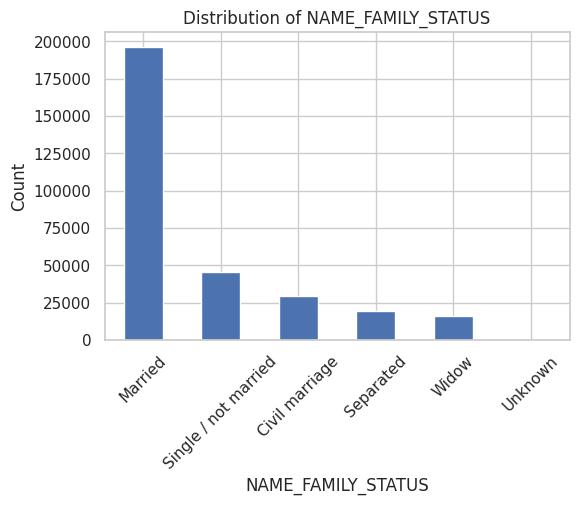

In [313]:
for col in ['CODE_GENDER', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS']:
    if col in df_ap.columns:
        plt.figure(figsize=(6,4))
        df_ap[col].value_counts().plot(kind='bar')
        plt.title(f"Distribution of {col}")
        plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.show()


🔹 5. Bivariate EDA – Default vs Key Variables

5.1 Numeric vs TARGET

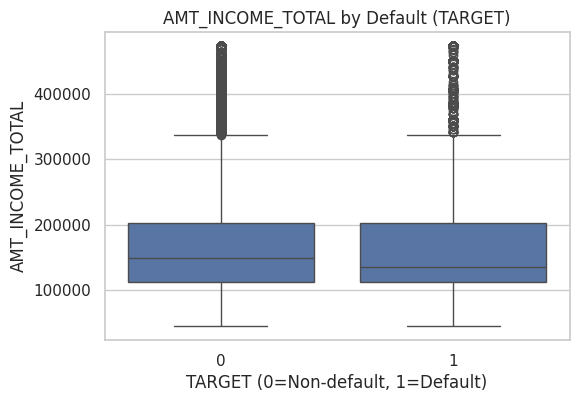

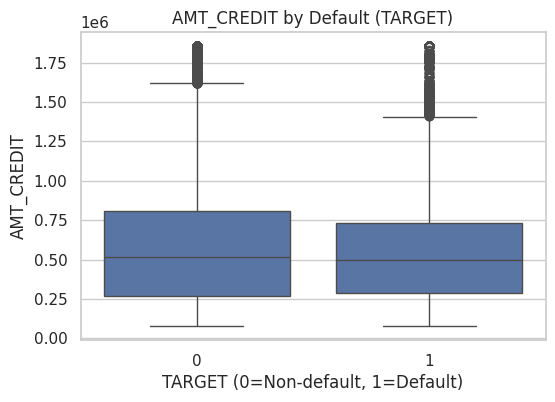

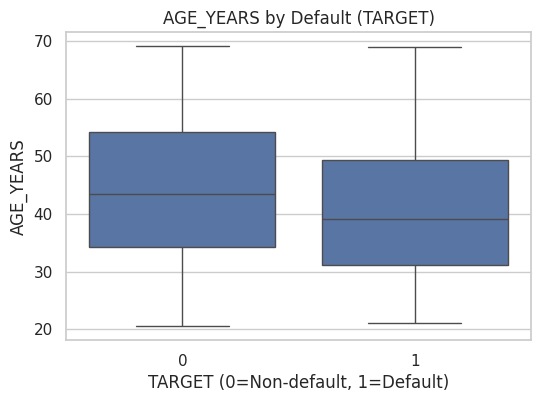

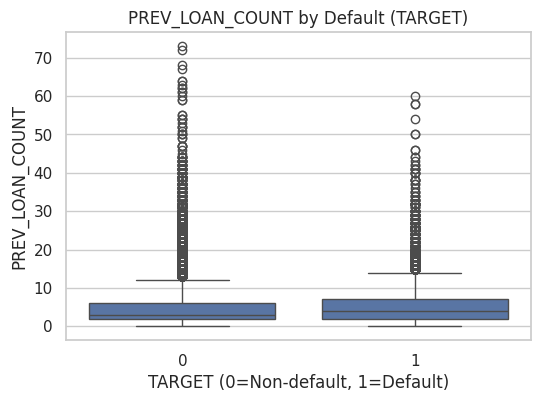

In [314]:
num_cols = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AGE_YEARS',  'PREV_LOAN_COUNT']

for col in num_cols:
    if col in df_ap.columns:
        plt.figure(figsize=(6,4))
        sns.boxplot(x='TARGET', y=col, data=df_ap)
        plt.title(f"{col} by Default (TARGET)")
        plt.xlabel("TARGET (0=Non-default, 1=Default)")
        plt.show()

Default Rate by Employment Status

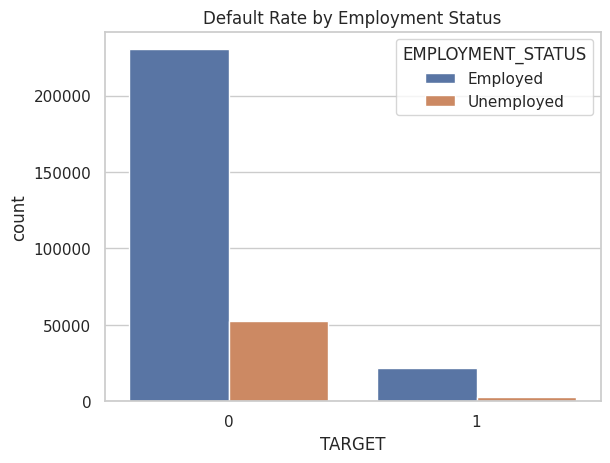

In [315]:
df_ap['EMPLOYMENT_STATUS'] = np.where(df_ap['EMP_YEARS'] <= 0, 'Unemployed', 'Employed')

sns.countplot(x='TARGET', hue='EMPLOYMENT_STATUS', data=df_ap)
plt.title("Default Rate by Employment Status")
plt.show()

5.2 Default Rate by Category

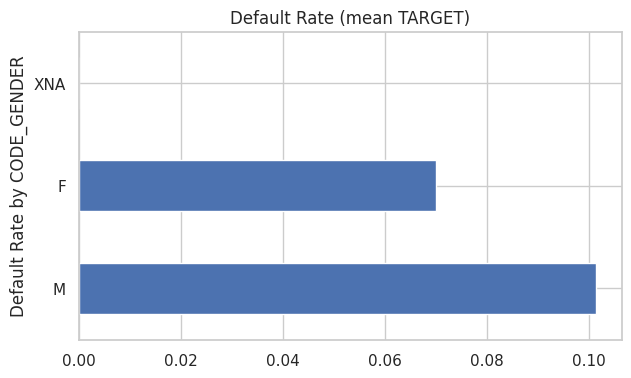

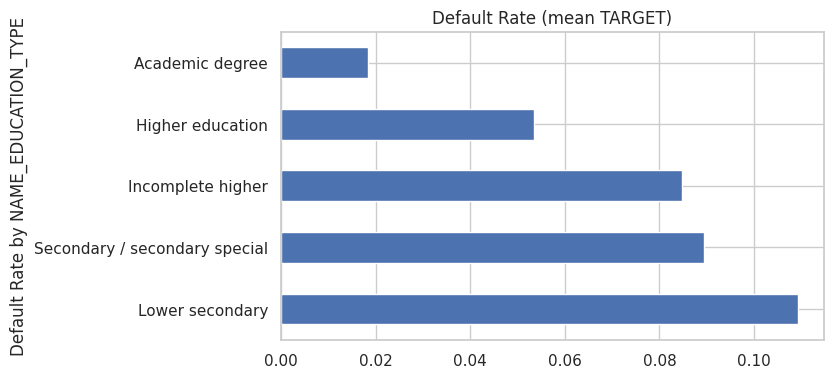

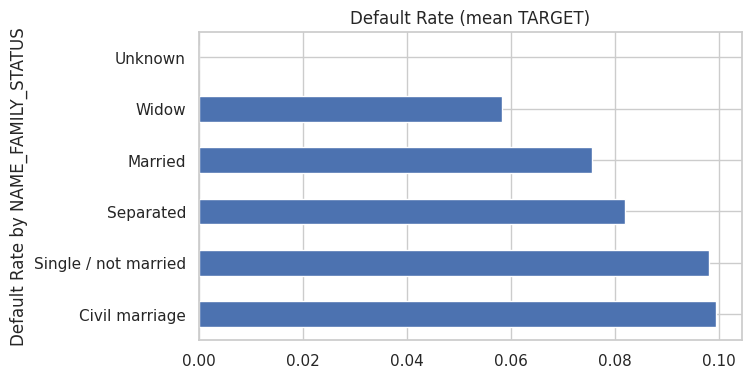

In [316]:
for col in ['CODE_GENDER', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS']:
    if col in df_ap.columns:
        rate = df_ap.groupby(col)['TARGET'].mean().sort_values(ascending=False)
        plt.figure(figsize=(7,4))
        rate.plot(kind='barh')
        plt.title("Default Rate (mean TARGET)")
        plt.ylabel(f"Default Rate by {col}")
        plt.show()


6. Multivariate EDA & Correlation

6.1 Scatterplots

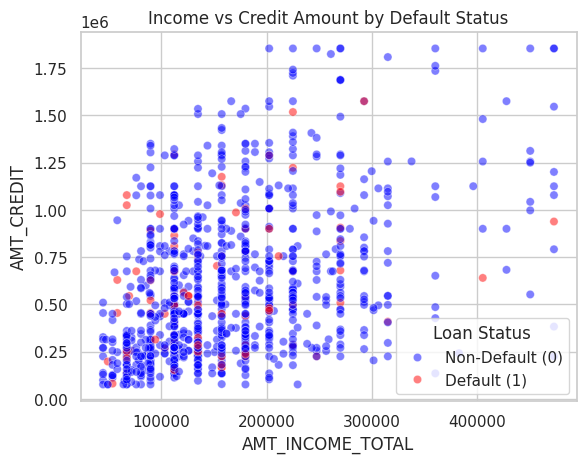

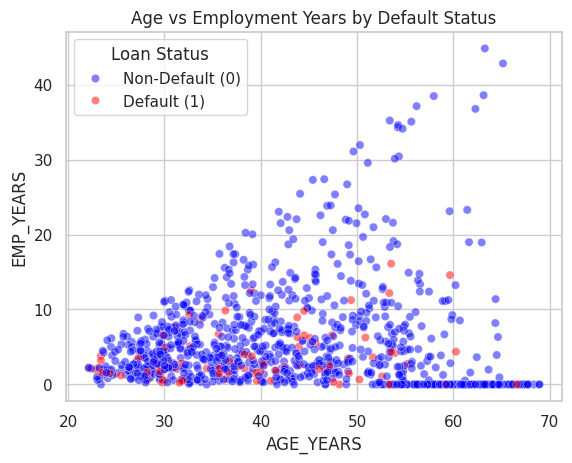

In [317]:
# Income vs Credit, colored by TARGET
sample = df_ap.sample(min(1000, len(df_ap)), random_state=42)

sns.scatterplot(data=sample,x='AMT_INCOME_TOTAL', y='AMT_CREDIT',hue='TARGET',alpha=0.5, palette=['blue','red'])
plt.title("Income vs Credit Amount by Default Status")
handles, labels = plt.gca().get_legend_handles_labels()
labels = ['Non-Default (0)', 'Default (1)']
plt.legend(handles, labels, title="Loan Status")
plt.show()

# Age vs Employment years

sns.scatterplot(data=sample,x='AGE_YEARS',y='EMP_YEARS',hue='TARGET',alpha=0.5, palette=['blue','red'])
plt.title("Age vs Employment Years by Default Status")
handles, labels = plt.gca().get_legend_handles_labels()
labels = ['Non-Default (0)', 'Default (1)']
plt.legend(handles, labels, title="Loan Status")
plt.show()


6.2 Correlation with TARGET

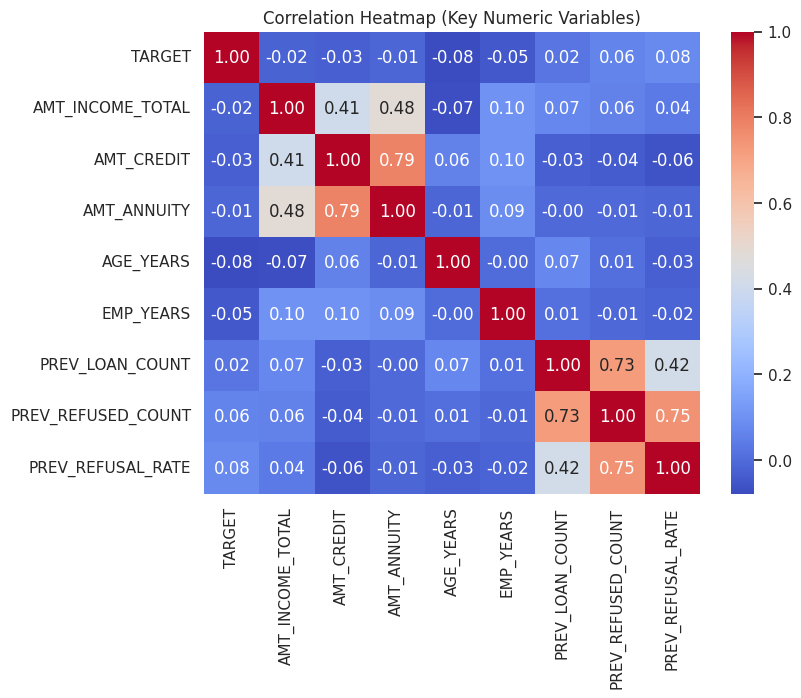

Correlation of numeric variables with TARGET:
TARGET                1.000000
PREV_REFUSAL_RATE     0.077894
PREV_REFUSED_COUNT    0.064756
PREV_LOAN_COUNT       0.023513
AMT_ANNUITY          -0.011086
AMT_INCOME_TOTAL     -0.023313
AMT_CREDIT           -0.030086
EMP_YEARS            -0.046052
AGE_YEARS            -0.078239
Name: TARGET, dtype: float64


In [318]:
corr_cols = ['TARGET', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
             'AGE_YEARS', 'EMP_YEARS', 'PREV_LOAN_COUNT',
             'PREV_REFUSED_COUNT', 'PREV_REFUSAL_RATE']

corr_cols = [c for c in corr_cols if c in df_ap.columns]
corr = df_ap[corr_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap (Key Numeric Variables)")
plt.show()

print("Correlation of numeric variables with TARGET:")
print(corr['TARGET'].sort_values(ascending=False))


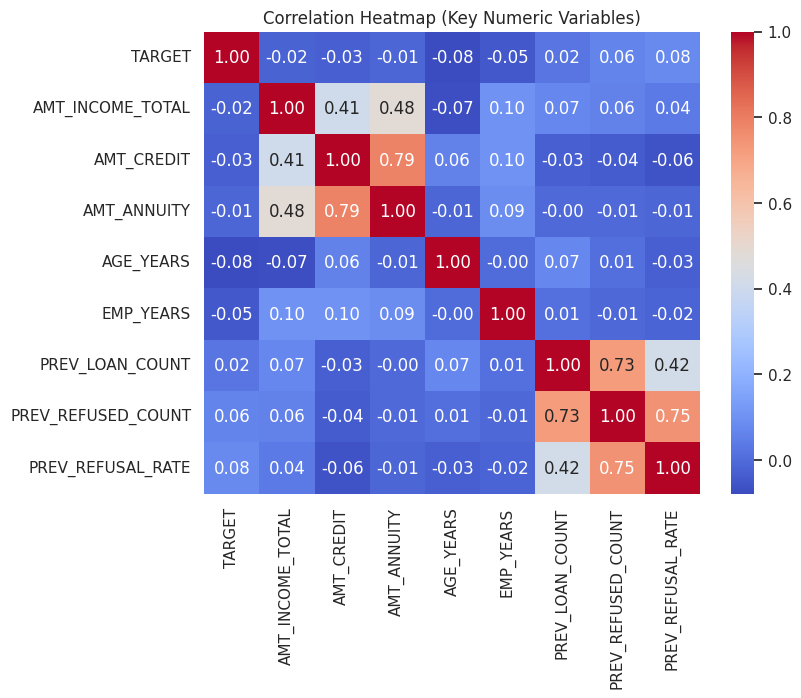

Correlation of numeric variables with TARGET:
TARGET                1.000000
PREV_REFUSAL_RATE     0.077894
PREV_REFUSED_COUNT    0.064756
PREV_LOAN_COUNT       0.023513
AMT_ANNUITY          -0.011086
AMT_INCOME_TOTAL     -0.023313
AMT_CREDIT           -0.030086
EMP_YEARS            -0.046052
AGE_YEARS            -0.078239
Name: TARGET, dtype: float64


In [319]:
corr_cols = ['TARGET', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
             'AGE_YEARS', 'EMP_YEARS', 'PREV_LOAN_COUNT',
             'PREV_REFUSED_COUNT', 'PREV_REFUSAL_RATE']

corr_cols = [c for c in corr_cols if c in df_ap.columns]
corr = df_ap[corr_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap (Key Numeric Variables)")
plt.show()

print("Correlation of numeric variables with TARGET:")
print(corr['TARGET'].sort_values(ascending=False))

#Positive correlation= increases default risk,directly proportional
#Negative correlation= reduces default risk, indirectly proportional



7. Hypothesis Testing (5 Tests)

Test 1 : Income vs Default

 Do defaulters have different income than non-defaulters?

- H0: Mean income of defaulters = mean income of non-defaulters  
- H1: Mean income of defaulters ≠ mean income of non-defaulters  

Test: Two-sample t-test (large sample, independent groups).


In [320]:
d1 = df_ap[df_ap['TARGET'] == 1]['AMT_INCOME_TOTAL']
d0 = df_ap[df_ap['TARGET'] == 0]['AMT_INCOME_TOTAL']

t_stat, p_val = stats.ttest_ind(d1, d0, equal_var=False)
print("T-statistic:", t_stat)
print("p-value:", p_val)

if p_val < 0.05:
    print("Conclusion: Reject H0 Income is statistically different between defaulters and non-defaulters.")
    print("Business: Income should be used as a risk driver in lending decisions.")
else:
    print("Conclusion: Fail to reject H0 → No strong evidence of income difference.")


T-statistic: -13.959941794015561
p-value: 3.7504357255339813e-44
Conclusion: Reject H0 Income is statistically different between defaulters and non-defaulters.
Business: Income should be used as a risk driver in lending decisions.


Test 2 – Gender vs Default (Proportion Test)

Is the default rate different across genders?

- H0: Default rate is the same for all genders (independent)
- H1: Default rate is different between genders(dependent)

Test: Chi-Square Independence Test

In [321]:
ct_gender = pd.crosstab(df_ap['CODE_GENDER'], df_ap['TARGET'])
print(ct_gender)
chi2, p_val, dof, expected = chi2_contingency(ct_gender)
print("Chi-square:", chi2)
print("p-value:", p_val)


TARGET            0      1
CODE_GENDER               
F            188278  14170
M             94404  10655
XNA               4      0
Chi-square: 920.7913340361749
p-value: 1.1290217848908289e-200


Test 3 – Education Level & Default (Chi-square)

Are education level and default behavior related?

- H0: Education level and default are independent  
- H1: Education level and default are associated  

Test: Chi-square test of independence.

In [322]:
edu_ct = pd.crosstab(df_ap['NAME_EDUCATION_TYPE'], df_ap['TARGET'])
print(edu_ct)

chi2, p_val, dof, expected = chi2_contingency(edu_ct)
print("Chi-square:", chi2)
print("p-value:", p_val)

if p_val < 0.05:
    print("Conclusion: Reject H0 → Education level is related to default.")
    print("Business: Certain education groups may need stricter lending criteria or lower exposure limits.")
else:
    print("Conclusion: Fail to reject H0 → No strong evidence that education affects default.")


TARGET                              0      1
NAME_EDUCATION_TYPE                         
Academic degree                   161      3
Higher education                70854   4009
Incomplete higher                9405    872
Lower secondary                  3399    417
Secondary / secondary special  198867  19524
Chi-square: 1019.2131873088356
p-value: 2.4476812052198174e-219
Conclusion: Reject H0 → Education level is related to default.
Business: Certain education groups may need stricter lending criteria or lower exposure limits.


Test 4 : Previous Rejections vs Current Default

Hypothesis 4: Do previous loan rejections predict higher default?

- H0: Customers with and without previous refusals have the same default rate  
- H1: Customers with previous refusals have a higher default rate  

Test: Proportion z-test (one-sided).

In [323]:
if 'PREV_REFUSED_COUNT' in df_ap.columns:
    df_ap['HAS_PREV_REFUSAL'] = (df_ap['PREV_REFUSED_COUNT'] > 0).astype(int)

    tab = pd.crosstab(df_ap['HAS_PREV_REFUSAL'], df_ap['TARGET']) #Builds contingency table
    print(tab)

    successes = tab[1].values     # defaulters
    nobs = tab.sum(axis=1).values # total in each group

    z_stat, p_val = proportions_ztest(successes, nobs, alternative='larger')
print("Z-statistic:", z_stat)
print("p-value:", p_val)

if p_val < 0.05:
        print("Conclusion: Reject H0 → Customers with previous refusals have higher default rate.")
        print("Business: Past refusals should be treated as a strong red flag and included in credit scorecards.")
else:
    print("Conclusion: Fail to reject H0 → No strong evidence that refusals increase default.")


TARGET                 0      1
HAS_PREV_REFUSAL               
0                 192744  14473
1                  89942  10352
Z-statistic: -31.846703925880004
p-value: 1.0
Conclusion: Fail to reject H0 → No strong evidence that refusals increase default.


Test 5 – Company Default Rate vs Industry Benchmark

Assume industry default rate = 5%.

H0: Company default rate = 5%.
H1: Company default rate > 5%.

Test: One-sample proportion z-test.

In [324]:
industry_rate = 0.05
company_rate = df_ap['TARGET'].mean()
n = len(df_ap)

z_stat = (company_rate - industry_rate) / np.sqrt(industry_rate * (1 - industry_rate) / n)
p_val = 1 - stats.norm.cdf(z_stat)

print("Company default rate:", company_rate)
print("Industry benchmark:", industry_rate)
print("Z-statistic:", z_stat)
print("p-value:", p_val)

if p_val < 0.05:
    print("Conclusion: Company default rate is significantly higher than industry benchmark.")
    print("Business: The lender needs to tighten approval policies or improve credit risk models.")
else:
    print("Conclusion: No strong evidence that company default is worse than industry level.")


Company default rate: 0.08072881945686496
Industry benchmark: 0.05
Z-statistic: 78.18607266160474
p-value: 0.0
Conclusion: Company default rate is significantly higher than industry benchmark.
Business: The lender needs to tighten approval policies or improve credit risk models.


8. Final Business Recommendations (Print Block)

## Final Business Recommendations

Based on EDA and hypothesis testing:

1️. Income & Affordability  
- Evidence suggests income is an important driver of default.  
- **Policy:**  
  - Set a minimum income threshold for certain loan sizes.  
  - Use debt-to-income ratio as a mandatory rule before approving large loans.

2️. Previous Loan Behaviour  
- Customers with more previous loans and especially with past refusals tend to show higher risk.  
- **Policy:**  
  - Include `PREV_LOAN_COUNT` and `PREV_REFUSED_COUNT` in internal scorecards.  
  - For high values, apply stricter documentation checks or reduce approved amount.

3️. Education & Customer Segments  
- If certain education levels show higher default, they form a higher-risk segment.  
- **Policy:**  
  - Use education as one of the softer segmentation variables, not as a hard rejection rule.  
  - Combine with income and employment type to design risk tiers.

4️. Benchmark vs Industry  
- If company’s default rate > industry benchmark, the lender is taking more risk for the same return.  
- **Policy:**  
  - Review approval strategies, risk cut-offs, and pricing.  
  - Tighten criteria for riskier profiles (low income, frequent past loans, poor external scores).

5️. Overall Credit Strategy  
- Use a combination of:  
  - Income level  
  - Employment stability  
  - Previous loan behavior  
  - External credit scores  
- to build a **simple internal credit score** and define:  
  - Approval / rejection  
  - Maximum credit limits  
  - Interest rate slabs  
  - Extra verification requirements
